In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from datetime import datetime
!pip install dataretrieval
from dataretrieval import nwis

In [2]:
# --- 1. Generate Sample Data (Replace with your actual DataFrame) ---
# Assuming your DataFrame 'df' is already loaded.
# For demonstration, let's create a sample DataFrame:
np.random.seed(42) # for reproducibility
dates = pd.to_datetime(pd.date_range(start='2020-01-01', periods=200, freq='D'))
x1 = np.sin(np.linspace(0, 50, 200)) + np.random.rand(200) * 0.5
x2 = np.cos(np.linspace(0, 40, 200)) * 0.8 + np.random.rand(200) * 0.3
y = 0.7 * x1 + 0.3 * x2 + np.sin(np.linspace(0, 60, 200)) * 0.5 + np.random.rand(200) * 0.2
df = pd.DataFrame({'date': dates, 'x1': x1, 'x2': x2, 'y': y})

print("Sample DataFrame Head:")
print(df.head())
print("\nDataFrame Info:")
df.info()

Sample DataFrame Head:
        date        x1        x2         y
0 2020-01-01  0.187270  0.992609  0.449497
1 2020-01-02  0.723978  0.809135  1.078516
2 2020-01-03  0.847626  0.784710  1.213366
3 2020-01-04  0.983721  0.928470  1.525502
4 2020-01-05  0.922185  0.736983  1.397738

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    200 non-null    datetime64[ns]
 1   x1      200 non-null    float64       
 2   x2      200 non-null    float64       
 3   y       200 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 6.4 KB


In [3]:
# Get the current time
current_time = datetime.now()

# Print the current time
print("Current time:", current_time)
startDate = "1995-10-01"
endDate = "2024-09-30"
model_site = [
              "13296000"
]
units_day = 365
missing_data_threshold = 0.90 *365

summer_months = [6,7,8]
summer_missing_data_threshold = 0.90 * (30+31+31)

site_info = nwis.get_info(sites= model_site )
site_info_df = pd.DataFrame( site_info[0] )
print("site_info_df:",site_info_df)
print("station_nm:",site_info_df['station_nm'][0])
site_info_df["site_no"]=site_info_df["site_no"].astype(str)
columns_to_save = ['site_no', 'station_nm','dec_lat_va', 'dec_long_va', 'drain_area_va', 'contrib_drain_area_va' ,   'alt_va'
                  # ,'alt_meth_cd', 'alt_acy_va', 'alt_datum_cd'
                  ]
filtered_df = site_info_df[columns_to_save]



parameterCode = ["00010","00060"  ]
dailyStreamtemp = nwis.get_dv(sites= model_site
                              , parameterCd=parameterCode, start=startDate, end=endDate)
dailyStreamtemp_df = pd.DataFrame( dailyStreamtemp[0] )
dailyStreamtemp_df = dailyStreamtemp_df.reset_index()
dailyStreamtemp_df['Date'] = dailyStreamtemp_df['datetime'].dt.date
dailyStreamtemp_df['Month'] = dailyStreamtemp_df['datetime'].dt.month
dailyStreamtemp_df['Year'] = dailyStreamtemp_df['datetime'].dt.year

shared_url = "https://drive.google.com/file/d/1z9w4rk21CCbbuOjwsru1pgkiOsYgVX6h/view?usp=share_link"
file_id = shared_url.split('/d/')[1].split('/')[0]
download_url = f"https://drive.google.com/uc?id={file_id}"
prism_df = pd.read_csv(download_url)
prism_df['date'] = pd.to_datetime( prism_df['date'])

def days_since_october_first(date):
    october_first = pd.Timestamp(year=date.year, month=10, day=1)
    days_difference = (date - october_first).days
    return days_difference if days_difference >= 0 else days_difference + 365

prism_df['Days_Since_October_1st'] =  prism_df['date'].apply(days_since_october_first)
#prism_df[ "rad_d"   ] = 2 * np.pi * prism_df[ "Days_Since_October_1st"   ] /365
prism_df["site_no"] =prism_df["site_no"].astype(str)
# Add a leading 0 to strings with exactly 7 characters
prism_df['site_no'] = prism_df['site_no'].apply(lambda x: '0' + x if len(x) == 7 else x)
prism_df["site_no"] =prism_df["site_no"].astype(str)
#print( prism_df)
prism_df['Date'] = prism_df['date'].dt.date

prism_df = prism_df[['tmean' , "site_no", 'Date'
#, "rad_d"
 ]]

dailyStreamtemp_df = dailyStreamtemp_df[[    'Date',
       'site_no',
  '00010_Mean', '00060_Mean'
  #,      'Month', 'Year'
   ]]

result = pd.merge(prism_df, dailyStreamtemp_df, on=['Date','site_no'], how='inner')

# Count the number of NaN values in each column
na_count = result.isna().sum()

# Drop rows with any NaN values
df_cleaned = result.dropna()

# Print the cleaned DataFrame
print(df_cleaned)

# Count the number of NaN values in each column
na_count = df_cleaned.isna().sum()

print(na_count)

Current time: 2025-05-09 20:49:45.379293
site_info_df:   agency_cd   site_no                              station_nm site_tp_cd  \
0      USGS  13296000  YANKEE FORK SALMON RIVER NR CLAYTON ID         ST   

   lat_va  long_va  dec_lat_va  dec_long_va coord_meth_cd  coord_acy_cd  ...  \
0  441632  1144404   44.278889  -114.733889             N             1  ...   

  reliability_cd gw_file_cd  nat_aqfr_cd  aqfr_cd  aqfr_type_cd well_depth_va  \
0            NaN   NNNNNNNN          NaN      NaN           NaN           NaN   

  hole_depth_va depth_src_cd  project_no                     geometry  
0           NaN          NaN         NaN  POINT (-114.73389 44.27889)  

[1 rows x 43 columns]
station_nm: YANKEE FORK SALMON RIVER NR CLAYTON ID
          tmean   site_no        Date  00010_Mean  00060_Mean
4      1.404000  13296000  2011-10-05         7.6       101.0
5      0.116000  13296000  2011-10-06         5.7       110.0
6      1.584000  13296000  2011-10-07         6.0        94.0
7 

In [4]:
features = ['x1', 'x2']
target = 'y'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
print(df.head())


DataFrame after Normalization Head:
        date        x1        x2         y
0 2020-01-01  0.476554  0.958601  0.561819
1 2020-01-02  0.699572  0.859425  0.791906
2 2020-01-03  0.750952  0.846222  0.841232
3 2020-01-04  0.807503  0.923931  0.955408
4 2020-01-05  0.781933  0.820423  0.908673


In [5]:
# --- 2. Preprocessing ---
# Select features and target
features = ['tmean',  '00060_Mean' ]
target = '00010_Mean'
# Normalize the data
# It's crucial to normalize all input features and the target variable for LSTMs.
# We'll use a separate scaler for the target 'y' to easily inverse transform predictions.
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

df = df_cleaned

# Fit and transform features
df[features] = scaler_features.fit_transform(df[features])

# Fit and transform target
# Reshape for scaler (expects 2D array)
df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))

print("\nDataFrame after Normalization Head:")
print(df.head())


DataFrame after Normalization Head:
      tmean   site_no        Date  00010_Mean  00060_Mean
4  0.529656  13296000  2011-10-05    0.466258    0.024156
5  0.500296  13296000  2011-10-06    0.349693    0.027134
6  0.533759  13296000  2011-10-07    0.368098    0.021840
7  0.566104  13296000  2011-10-08    0.392638    0.020615
8  0.586118  13296000  2011-10-09    0.337423    0.019159


<ipython-input-5-29c404d0e562>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[features] = scaler_features.fit_transform(df[features])
<ipython-input-5-29c404d0e562>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[target] = scaler_target.fit_transform(df[target].values.reshape(-1, 1))


In [6]:
# --- 3. Create Sequences for LSTM ---
# LSTMs require data in a 3D format: (samples, timesteps, features)
# 'timesteps' (also known as look_back) determines how many previous time steps
# the LSTM will consider to predict the next value.

look_back = 10 # You can adjust this based on your data's seasonality/dependencies

def create_sequences(data, look_back, features_cols, target_col):
    X, Y = [], []
    # Ensure data is a numpy array for efficient indexing
    data_np = data[features_cols + [target_col]].values # include target for sequence alignment

    # Features are the first 'num_features' columns, target is the last column.
    num_features = len(features_cols)

    for i in range(len(data_np) - look_back):
        # X: look_back historical features (x1, x2)
        X.append(data_np[i:(i + look_back), :num_features])
        # Y: the 'y' value at the current time step (i + look_back)
        Y.append(data_np[i + look_back, num_features]) # Target is the last column

    return np.array(X), np.array(Y)

X, Y = create_sequences(df, look_back, features, target)

print(f"\nShape of X (samples, timesteps, features): {X.shape}")
print(f"Shape of Y (samples, target_value): {Y.shape}")


Shape of X (samples, timesteps, features): (4262, 10, 2)
Shape of Y (samples, target_value): (4262,)


In [7]:
# --- 4. Train-Test Split (Time Series Split) ---
# It's crucial to split time series data chronologically to avoid data leakage.
train_size = int(len(X) * 0.8) # e.g., 80% for training, 20% for testing
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(Y)]

print(f"Train samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")

Train samples: 3409
Test samples: 853


In [8]:
# --- 5. Build LSTM Model ---
model = Sequential()
# First LSTM layer with return_sequences=True to pass sequences to the next LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(look_back, len(features))))
model.add(Dropout(0.2)) # Dropout to prevent overfitting

# Second LSTM layer
model.add(LSTM(units=50, return_sequences=False)) # return_sequences=False for the last LSTM layer
model.add(Dropout(0.2))

# Dense output layer for regression (predicting a single value 'y')
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0722 - val_loss: 0.0085
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - val_loss: 0.0094
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0113 - val_loss: 0.0069
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0099 - val_loss: 0.0074
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094 - val_loss: 0.0064
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0094 - val_loss: 0.0072
Epoch 8/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 9/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0087 - val_loss: 0.0058
Epoch 10/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0077 - val_loss: 0.0068
Epoch 11/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0081 - val_loss: 0.0054
Epoch 12/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.

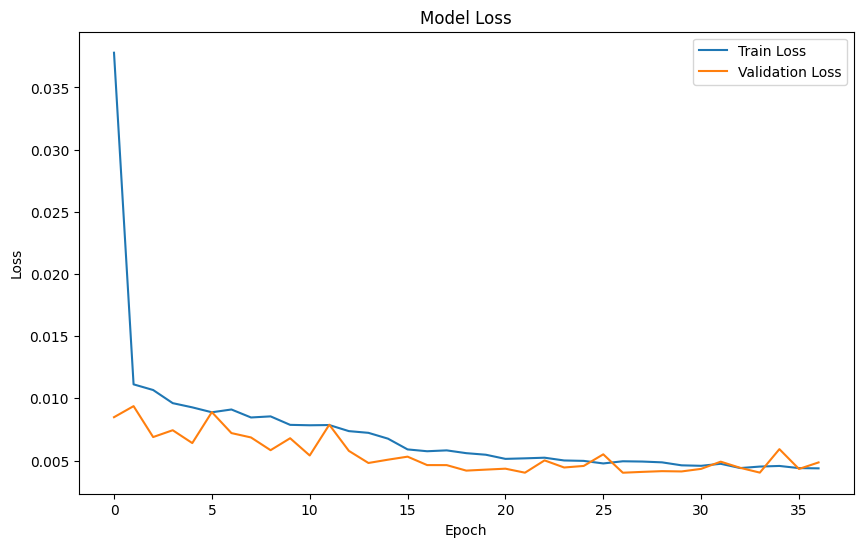

In [9]:
# --- 6. Train the Model ---
# EarlyStopping to stop training when a monitored metric has stopped improving.
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, Y_train,
                    epochs=100, # You can increase epochs, EarlyStopping will handle it
                    batch_size=32,
                    validation_split=0.2, # Use a portion of training data for validation
                    callbacks=[early_stopping],
                    verbose=1)

# Plot training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [10]:
# --- 7. Evaluate the Model ---
train_loss = model.evaluate(X_train, Y_train, verbose=0)
test_loss = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTrain Loss (MSE): {train_loss:.4f}")
print(f"Test Loss (MSE): {test_loss:.4f}")


Train Loss (MSE): 0.0039
Test Loss (MSE): 0.0065


In [11]:
# --- 8. Make Predictions ---
# Make predictions on the test set
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values to the original scale
Y_pred = scaler_target.inverse_transform(Y_pred_scaled)
Y_test_original = scaler_target.inverse_transform(Y_test.reshape(-1, 1))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(Y_test_original, Y_pred))
print(f"Test RMSE: {rmse:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Test RMSE: 1.3109


In [12]:
#Y_pred
#Y_test_original
#print(Y_pred .shape)
#df_cleaned[train_size:len(Y)]['Date']


dt_ys = df_cleaned[train_size:len(Y)]#['Date']
dt_ys['Y_pred'] = Y_pred
dt_ys['Y_test_original']= Y_test_original

dt_ys[['Date','Y_pred', 	'Y_test_original']]

dt_ys['Date'] = pd.to_datetime(df['Date'])

summer_df = dt_ys[ dt_ys['Date'].dt.month.isin([6, 7, 8])]

summer_df

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(summer_df['Y_test_original'], summer_df['Y_pred']))
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 1.3135


<ipython-input-12-c52d9b2102c1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_pred'] = Y_pred
<ipython-input-12-c52d9b2102c1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dt_ys['Y_test_original']= Y_test_original
<ipython-input-12-c52d9b2102c1>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

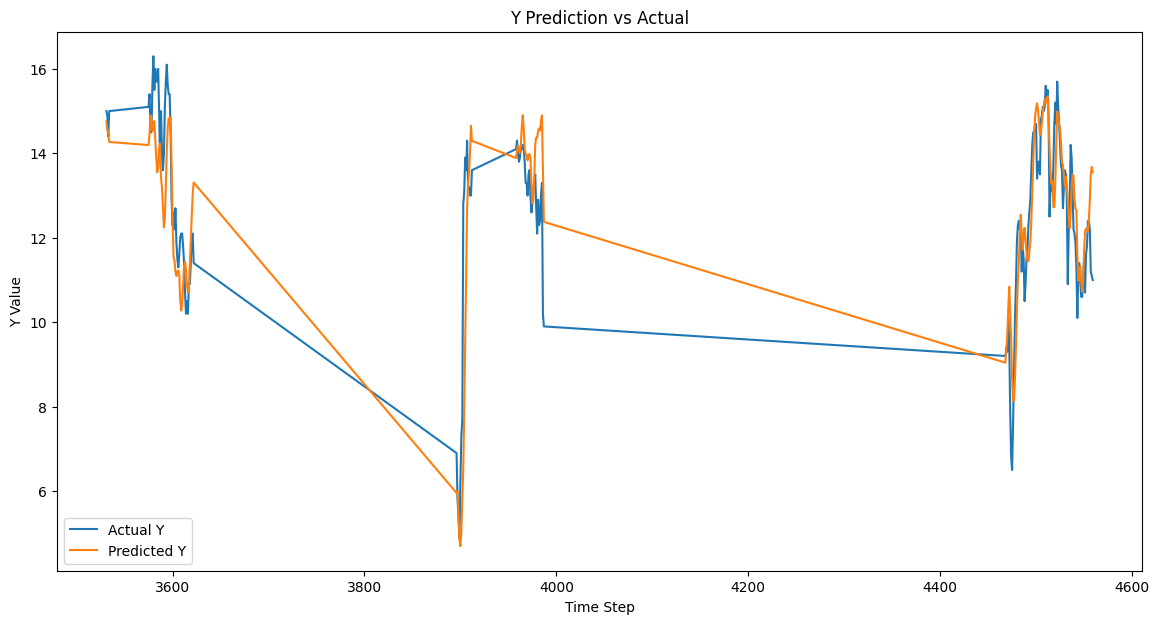

In [13]:
plt.figure(figsize=(14, 7))
plt.plot( summer_df['Y_test_original'], label='Actual Y')
plt.plot( summer_df['Y_pred'], label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

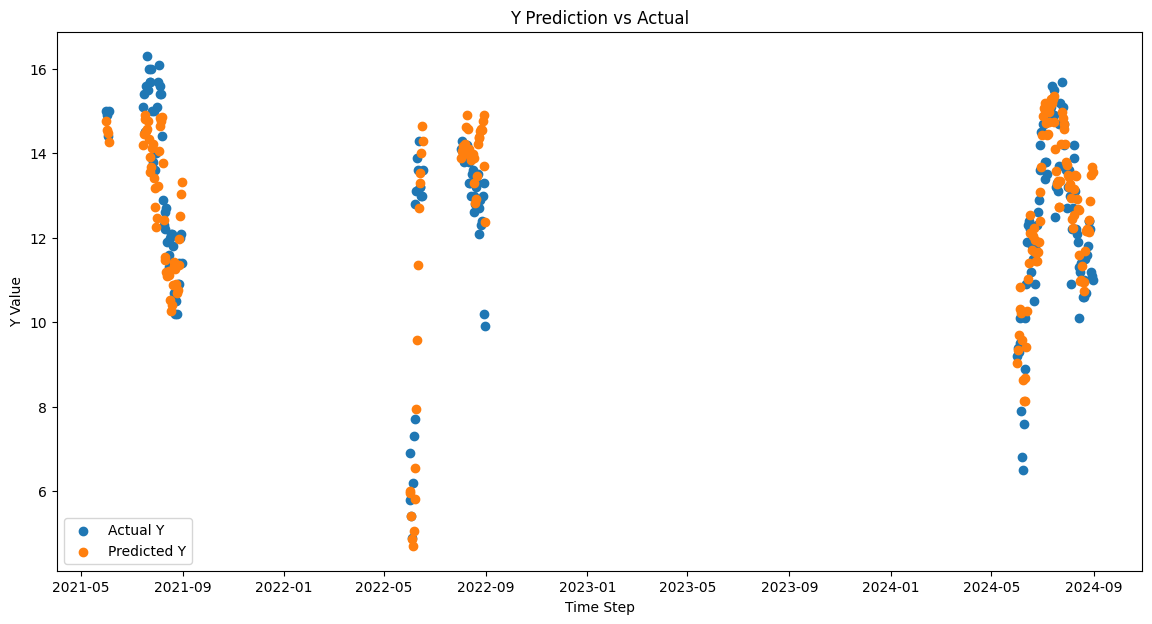

In [14]:
plt.figure(figsize=(14, 7))
plt.scatter(summer_df['Date'], summer_df['Y_test_original'], label='Actual Y')
plt.scatter(summer_df['Date'], summer_df['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

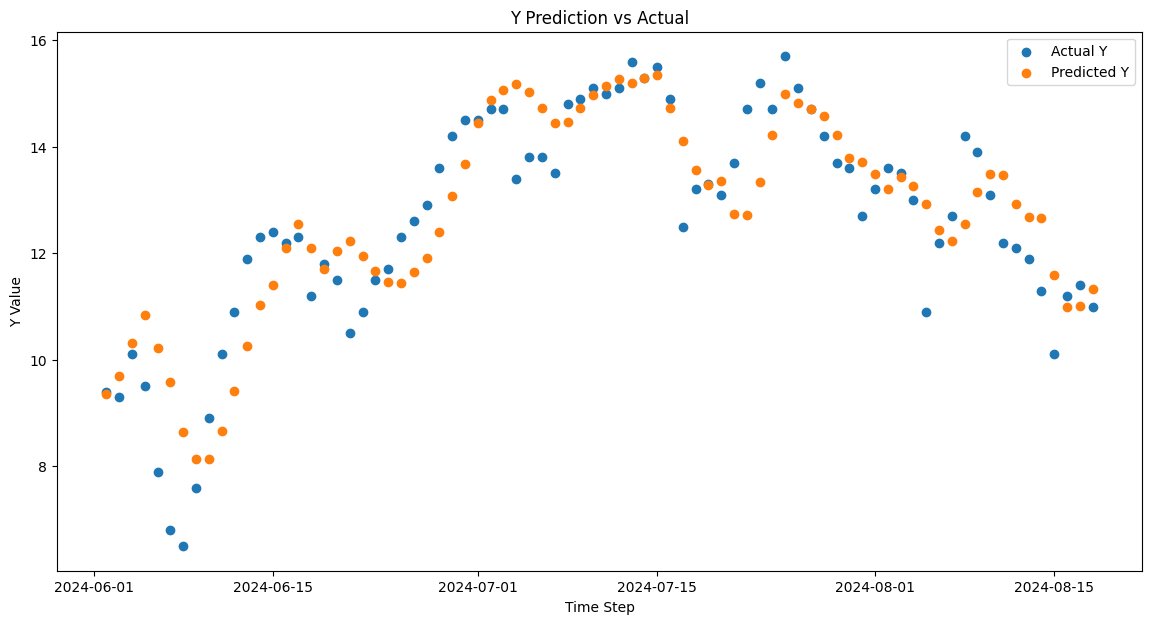

In [15]:
small= summer_df[100:178]

plt.figure(figsize=(14, 7))
plt.scatter( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.scatter( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

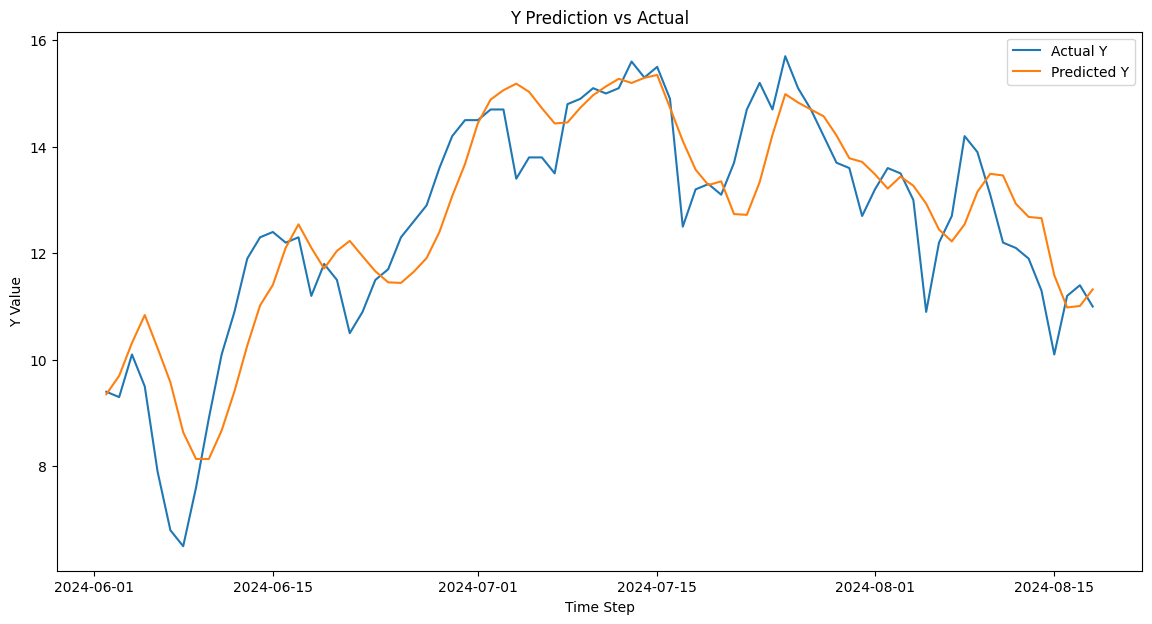

In [16]:
small= summer_df[100:178]

plt.figure(figsize=(14, 7))
plt.plot( small['Date'],  small['Y_test_original'], label='Actual Y')
plt.plot( small['Date'],  small['Y_pred'], label='Predicted Y')



plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

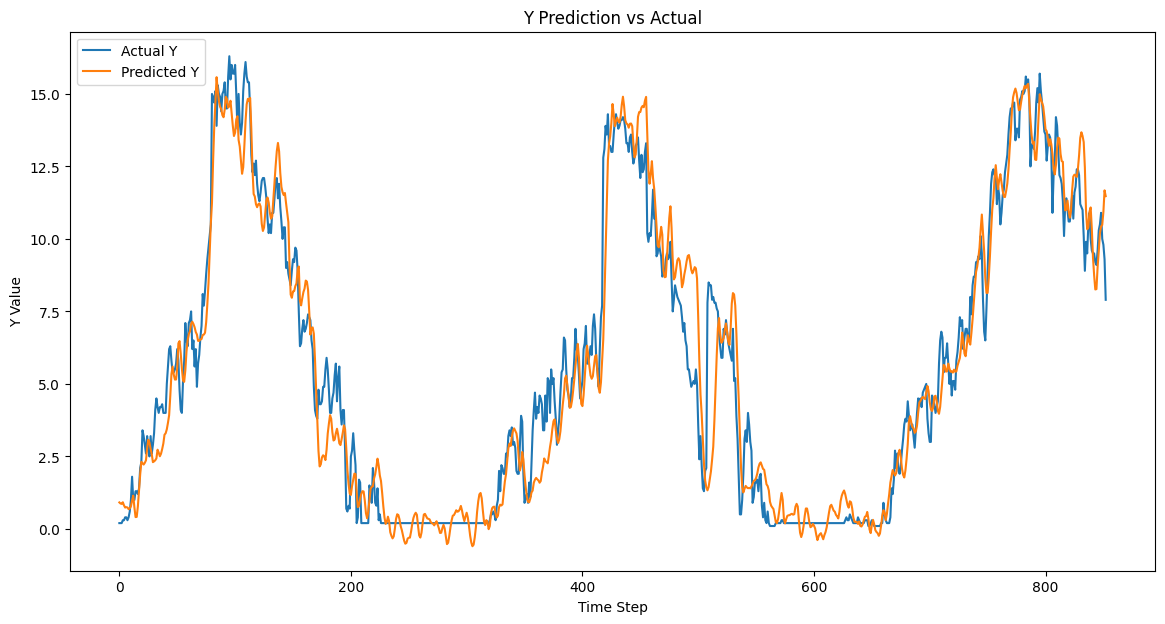

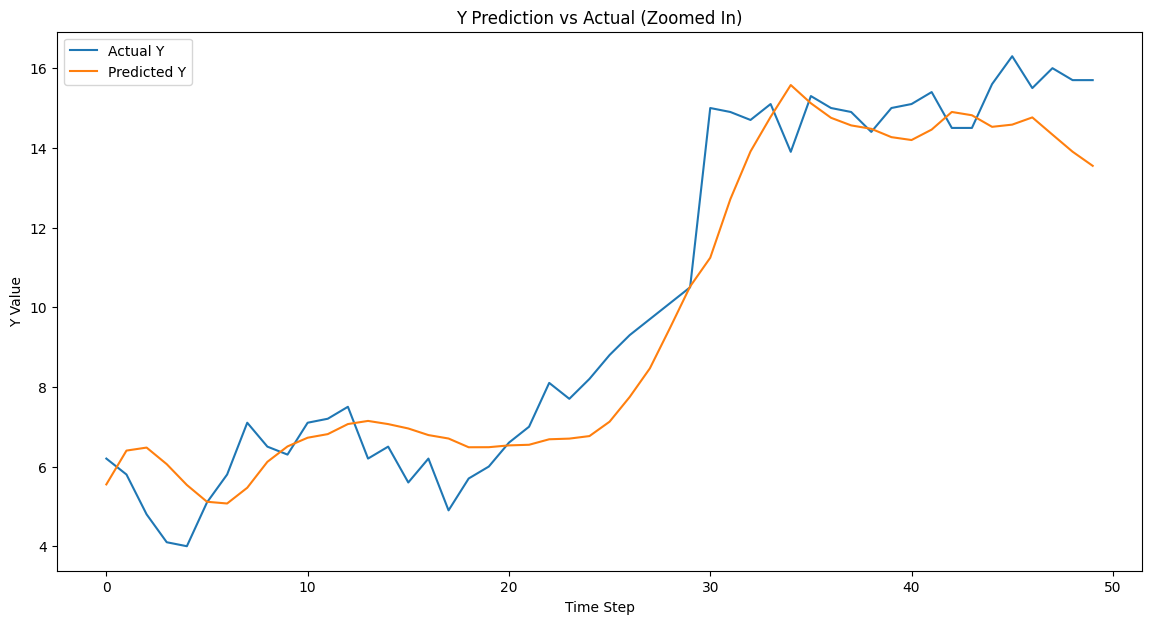

In [17]:



# --- 9. Visualize Predictions vs. Actual ---
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original, label='Actual Y')
plt.plot(Y_pred, label='Predicted Y')
plt.title('Y Prediction vs Actual')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()

# Optional: Plot a smaller segment for better detail
plt.figure(figsize=(14, 7))
plt.plot(Y_test_original[50:100], label='Actual Y')
plt.plot(Y_pred[50:100], label='Predicted Y')
plt.title('Y Prediction vs Actual (Zoomed In)')
plt.xlabel('Time Step')
plt.ylabel('Y Value')
plt.legend()
plt.show()